In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder,OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           roc_auc_score, confusion_matrix, roc_curve, classification_report,
                           make_scorer)
# Required Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import lightgbm as lgb


In [ ]:
# ==============================================
# STEP 1: LOAD DATASET
# ==============================================
print("\nSTEP 1: LOADING DATASET")
print("-" * 30)

# Load the dataset
df = pd.read_csv('/content/hospital_readmissions.csv')  # Update path as needed
print(f"Dataset loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")

# Basic dataset info
print(f"\nDataset Info:")
print(df.info())
print(f"\nFirst 5 rows:")
print(df.head())

# Missing values check
missing_values = df.isnull().sum()
print(f"\nMissing values:")
print(missing_values[missing_values > 0])

# Target variable distribution
print(f"\nTarget variable distribution:")
target_dist = df['readmitted'].value_counts()
print(target_dist)
print(f"Percentages:")
print(df['readmitted'].value_counts(normalize=True) * 100)


STEP 1: LOADING DATASET
------------------------------
Dataset loaded: 25,000 rows × 17 columns

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                25000 non-null  object
 1   time_in_hospital   25000 non-null  int64 
 2   n_lab_procedures   25000 non-null  int64 
 3   n_procedures       25000 non-null  int64 
 4   n_medications      25000 non-null  int64 
 5   n_outpatient       25000 non-null  int64 
 6   n_inpatient        25000 non-null  int64 
 7   n_emergency        25000 non-null  int64 
 8   medical_specialty  25000 non-null  object
 9   diag_1             25000 non-null  object
 10  diag_2             25000 non-null  object
 11  diag_3             25000 non-null  object
 12  glucose_test       25000 non-null  object
 13  A1Ctest            25000 non-null  object
 14  change             250


STEP 2: EXPLORATORY DATA ANALYSIS (EDA)
------------------------------


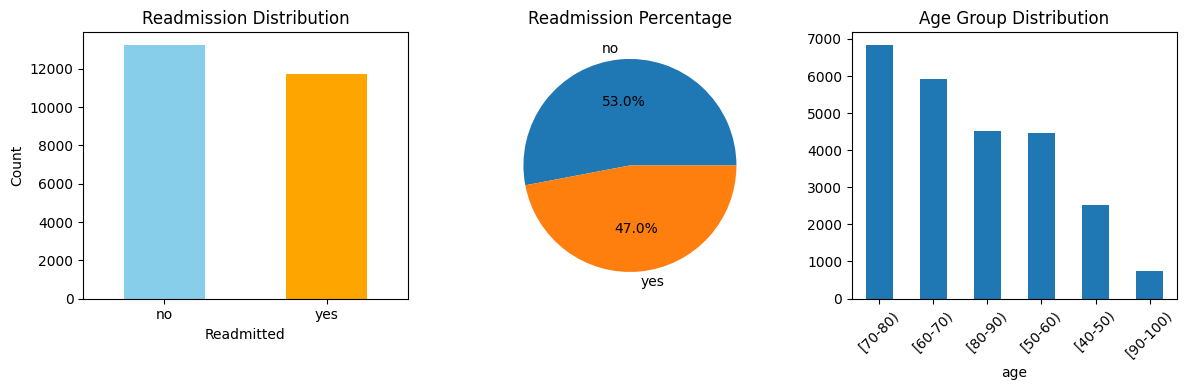

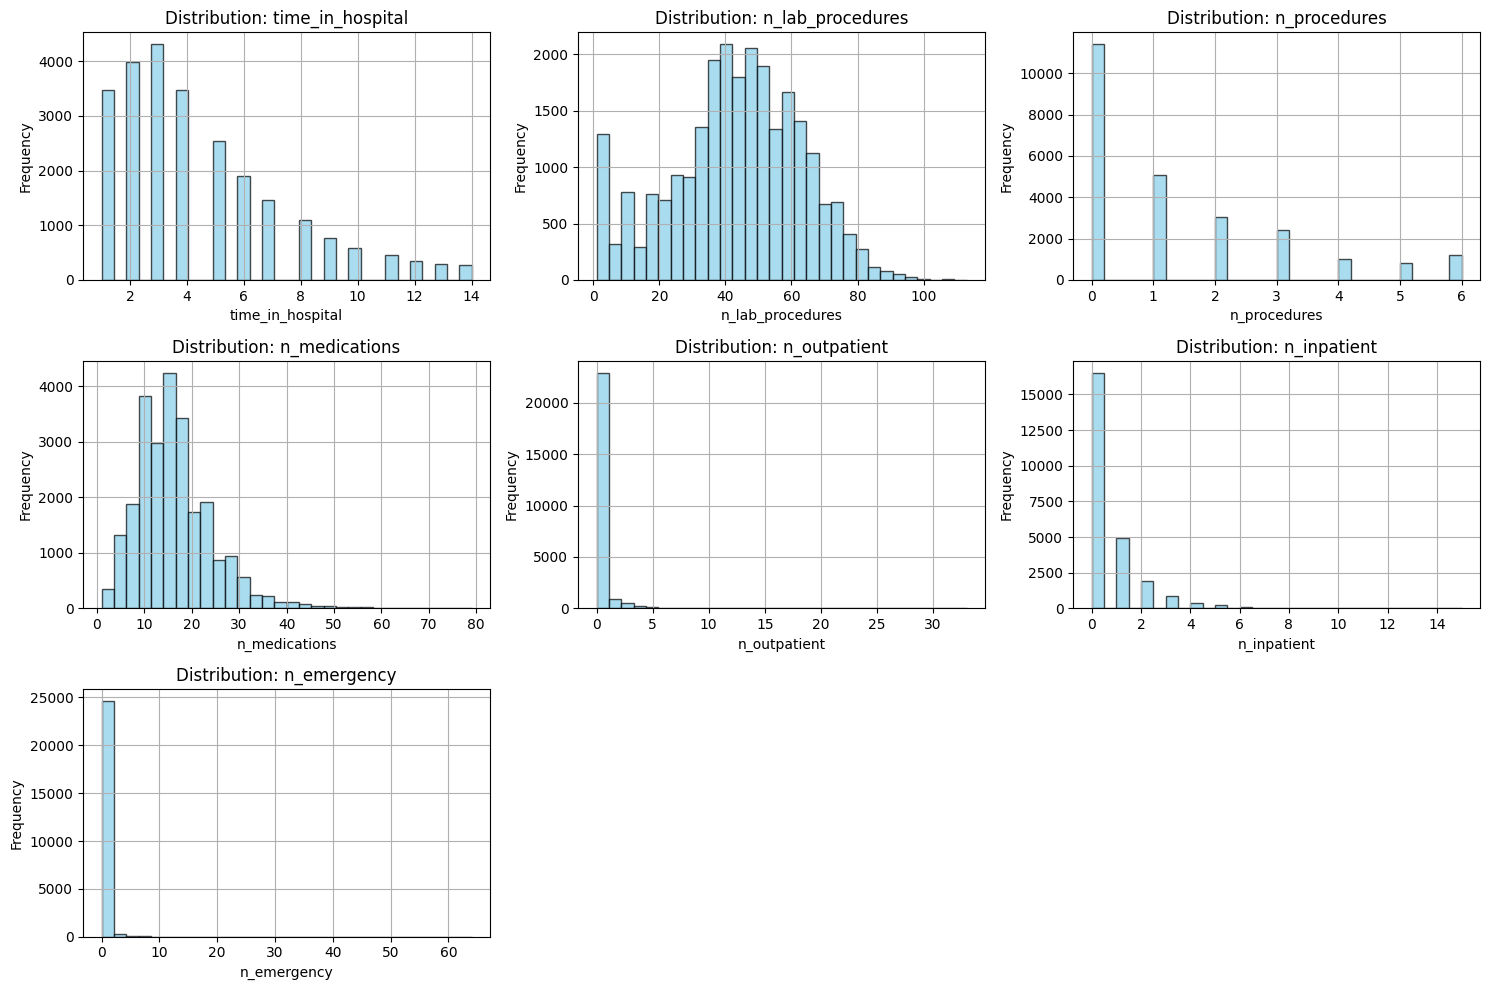


Statistical Summary of Numerical Features:
       time_in_hospital  n_lab_procedures  n_procedures  n_medications  \
count       25000.00000       25000.00000  25000.000000   25000.000000   
mean            4.45332          43.24076      1.352360      16.252400   
std             3.00147          19.81862      1.715179       8.060532   
min             1.00000           1.00000      0.000000       1.000000   
25%             2.00000          31.00000      0.000000      11.000000   
50%             4.00000          44.00000      1.000000      15.000000   
75%             6.00000          57.00000      2.000000      20.000000   
max            14.00000         113.00000      6.000000      79.000000   

       n_outpatient   n_inpatient   n_emergency  
count  25000.000000  25000.000000  25000.000000  
mean       0.366400      0.615960      0.186600  
std        1.195478      1.177951      0.885873  
min        0.000000      0.000000      0.000000  
25%        0.000000      0.000000      

In [ ]:
# ==============================================
# STEP 2: EXPLORATORY DATA ANALYSIS (EDA)
# ==============================================
print("\nSTEP 2: EXPLORATORY DATA ANALYSIS (EDA)")
print("-" * 30)

# 2.1 Target Distribution Visualization
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
df['readmitted'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Readmission Distribution')
plt.xlabel('Readmitted')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 3, 2)
df['readmitted'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%')
plt.title('Readmission Percentage')
plt.ylabel('')

plt.subplot(1, 3, 3)
df['age'].value_counts().plot(kind='bar')
plt.title('Age Group Distribution')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 2.2 Numerical Features Distribution
numerical_cols = ['time_in_hospital', 'n_lab_procedures', 'n_procedures',
                 'n_medications', 'n_outpatient', 'n_inpatient', 'n_emergency']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    df[col].hist(bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title(f'Distribution: {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# 2.3 Statistical Summary
print("\nStatistical Summary of Numerical Features:")
print(df[numerical_cols].describe())


 STEP 3: OUTLIER HANDLING
--------------------------------------------------
Outlier Analysis (Adjusted IQR Method - 3x IQR for skewed data):
time_in_hospital: 0 outliers (0.00%)
n_lab_procedures: 0 outliers (0.00%)
n_procedures: 0 outliers (0.00%)
n_medications: 149 outliers (0.60%)
n_outpatient: 4141 outliers (16.56%)
n_inpatient: 437 outliers (1.75%)
n_emergency: 2728 outliers (10.91%)

Pre-Capping Visualizations:


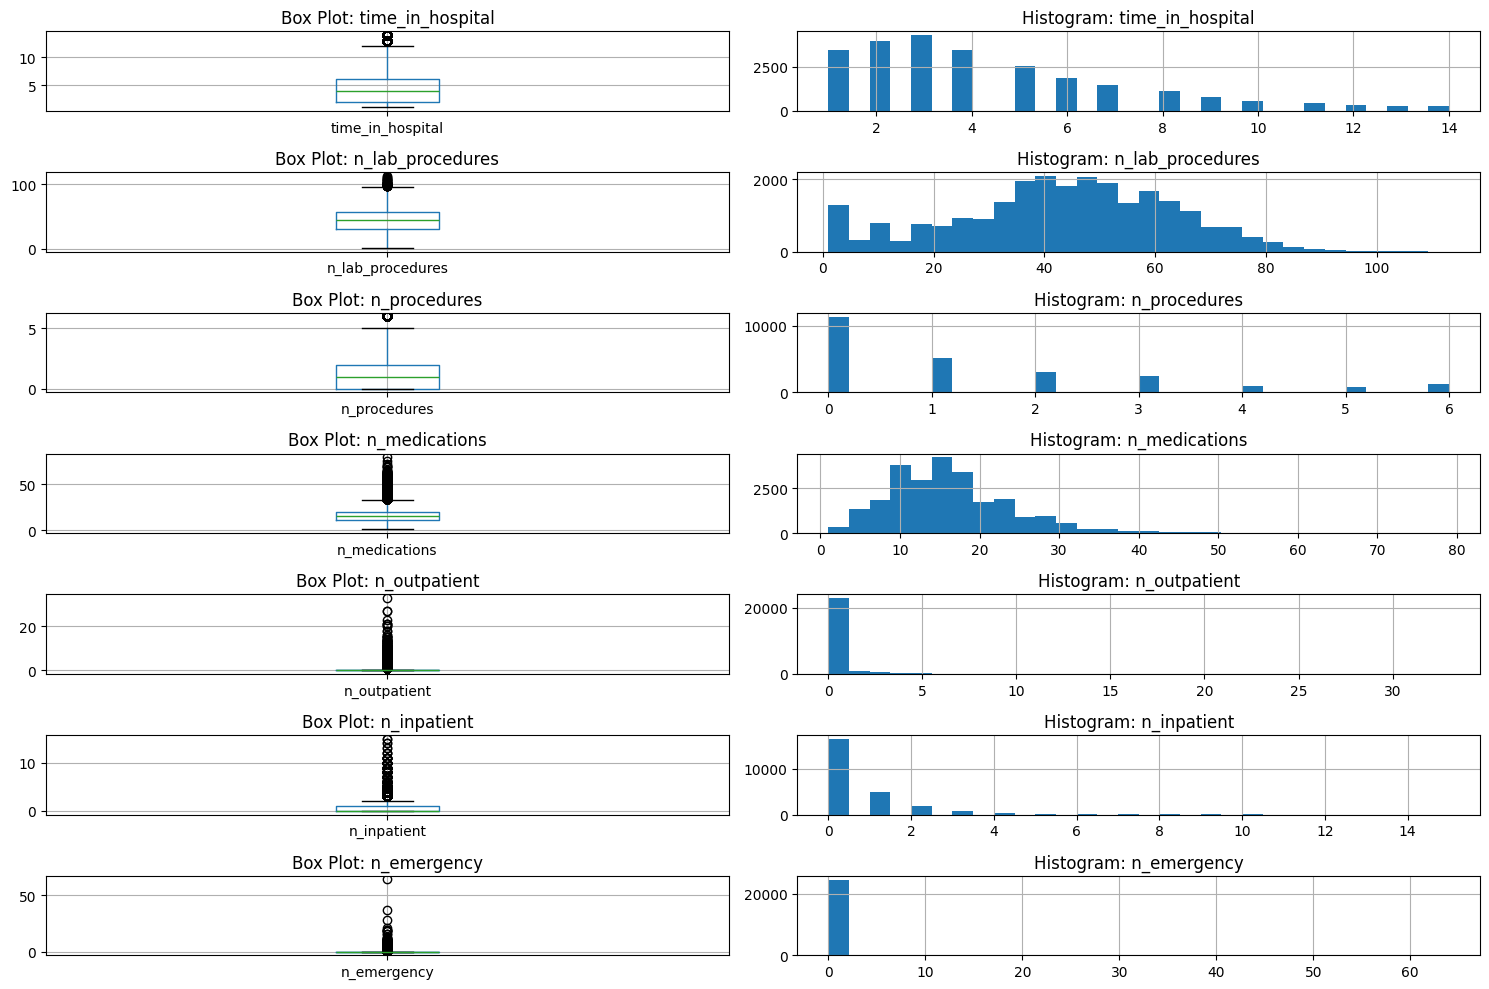


Applying Outlier Capping (1st/99th Percentiles)...
Outliers successfully capped!

Pre-Capping Summary:
       time_in_hospital  n_lab_procedures  n_procedures  n_medications  \
count       25000.00000       25000.00000  25000.000000   25000.000000   
mean            4.45332          43.24076      1.352360      16.252400   
std             3.00147          19.81862      1.715179       8.060532   
min             1.00000           1.00000      0.000000       1.000000   
25%             2.00000          31.00000      0.000000      11.000000   
50%             4.00000          44.00000      1.000000      15.000000   
75%             6.00000          57.00000      2.000000      20.000000   
max            14.00000         113.00000      6.000000      79.000000   

       n_outpatient   n_inpatient   n_emergency  
count  25000.000000  25000.000000  25000.000000  
mean       0.366400      0.615960      0.186600  
std        1.195478      1.177951      0.885873  
min        0.000000      0.00

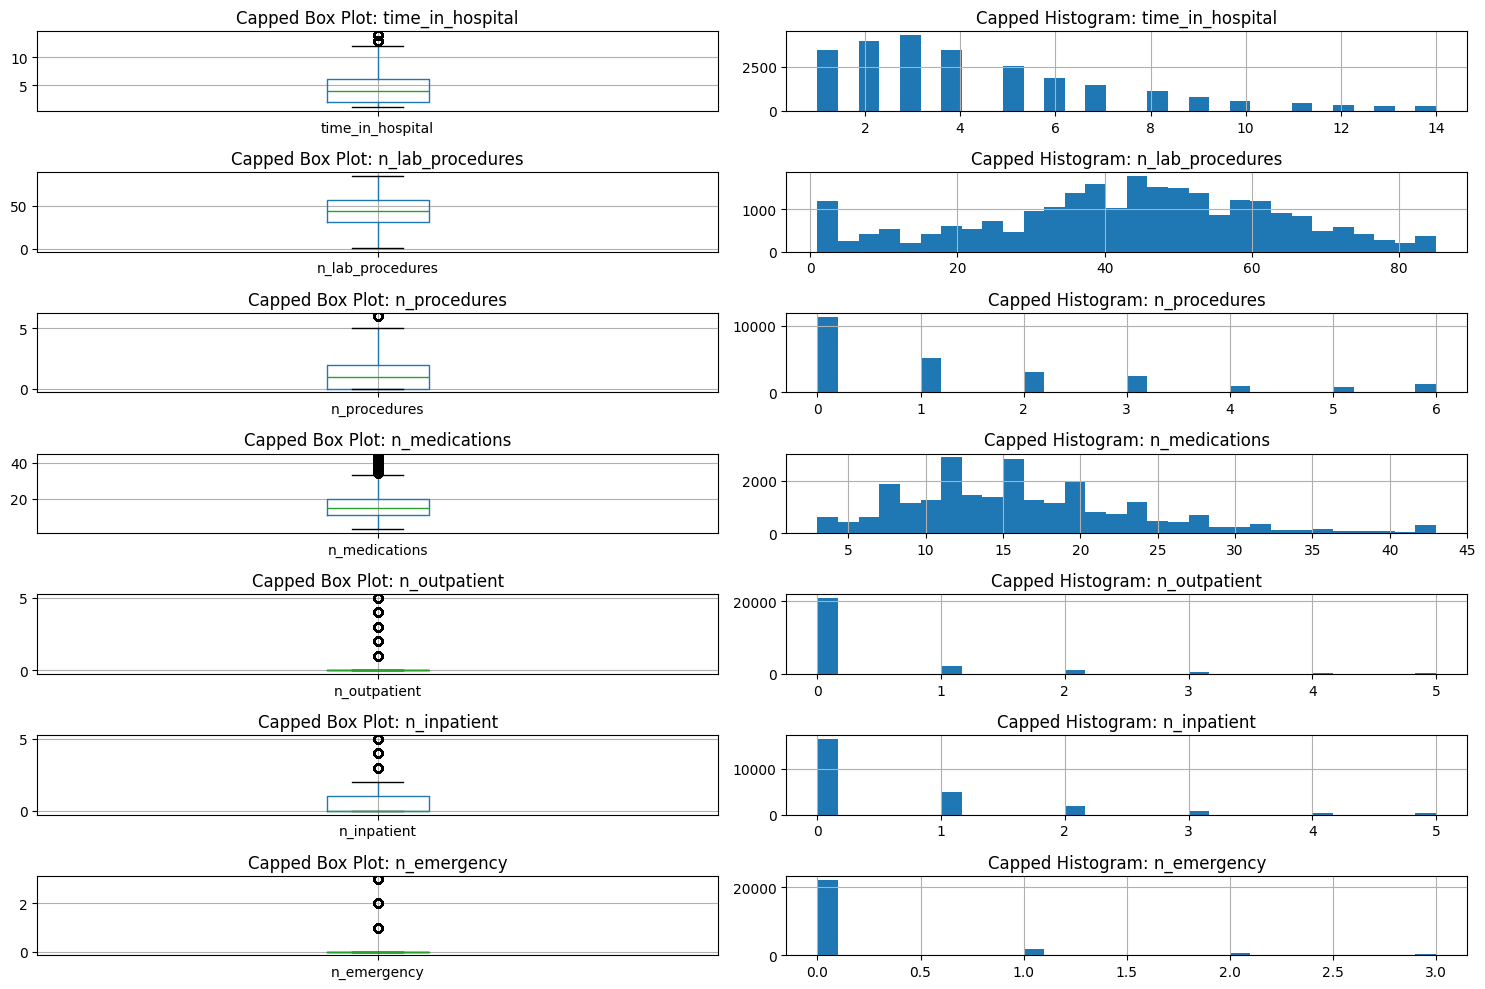

Processing complete. Use df_processed for further analysis.


In [ ]:
# ==============================================
# STEP 3: OUTLIER HANDLING
# ==============================================
print("\n STEP 3: OUTLIER HANDLING")
print("-" * 50)
numerical_cols = ['time_in_hospital', 'n_lab_procedures', 'n_procedures', 'n_medications',
                  'n_outpatient', 'n_inpatient', 'n_emergency']

# Step 3: Outlier Detection and Summary using IQR (with adjusted multiplier for skewness)
outlier_summary = {}
print("Outlier Analysis (Adjusted IQR Method - 3x IQR for skewed data):")
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # Use 3x IQR to be less sensitive to skewness (based on histograms showing long tails)
    lower_bound = max(0, Q1 - 3 * IQR)  # Ensure non-negative for count data
    upper_bound = Q3 + 3 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_count = len(outliers)
    outlier_percentage = (outlier_count / len(df)) * 100

    outlier_summary[col] = {
        'count': outlier_count,
        'percentage': outlier_percentage,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }

    print(f"{col}: {outlier_count} outliers ({outlier_percentage:.2f}%)")

# Step 4: Pre-capping Visualization - Box Plots and Histograms
print("\nPre-Capping Visualizations:")
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols), 2, 2*i - 1)  # Box plot
    df.boxplot(column=col)
    plt.title(f'Box Plot: {col}')

    plt.subplot(len(numerical_cols), 2, 2*i)  # Histogram
    df[col].hist(bins=30)
    plt.title(f'Histogram: {col}')
plt.tight_layout()
plt.show()

# Step 5: Outlier Management - Capping with Percentiles (alternative to IQR for skewness)
# Using 1st and 99th percentiles to cap, preserving most data while handling extremes
# This is more appropriate than 1.5x IQR based on histograms (heavy skew, long tails)
print("\nApplying Outlier Capping (1st/99th Percentiles)...")
df_processed = df.copy()

for col in numerical_cols:
    lower_bound = max(0, df_processed[col].quantile(0.01))  # 1st percentile, floored at 0
    upper_bound = df_processed[col].quantile(0.99)  # 99th percentile

    # Cap the values
    df_processed[col] = np.where(df_processed[col] < lower_bound, lower_bound, df_processed[col])
    df_processed[col] = np.where(df_processed[col] > upper_bound, upper_bound, df_processed[col])

print("Outliers successfully capped!")

# Step 6: Post-Capping Validation - Summaries and Visualizations
print("\nPre-Capping Summary:")
print(df[numerical_cols].describe())

print("\nPost-Capping Summary:")
print(df_processed[numerical_cols].describe())

print("\nPost-Capping Visualizations:")
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols), 2, 2*i - 1)  # Box plot
    df_processed.boxplot(column=col)
    plt.title(f'Capped Box Plot: {col}')

    plt.subplot(len(numerical_cols), 2, 2*i)  # Histogram
    df_processed[col].hist(bins=30)
    plt.title(f'Capped Histogram: {col}')
plt.tight_layout()
plt.show()

# Step 7: Optional - Export Processed Data
# df_processed.to_csv('hospital_readmissions_processed.csv', index=False)
print("Processing complete. Use df_processed for further analysis.")

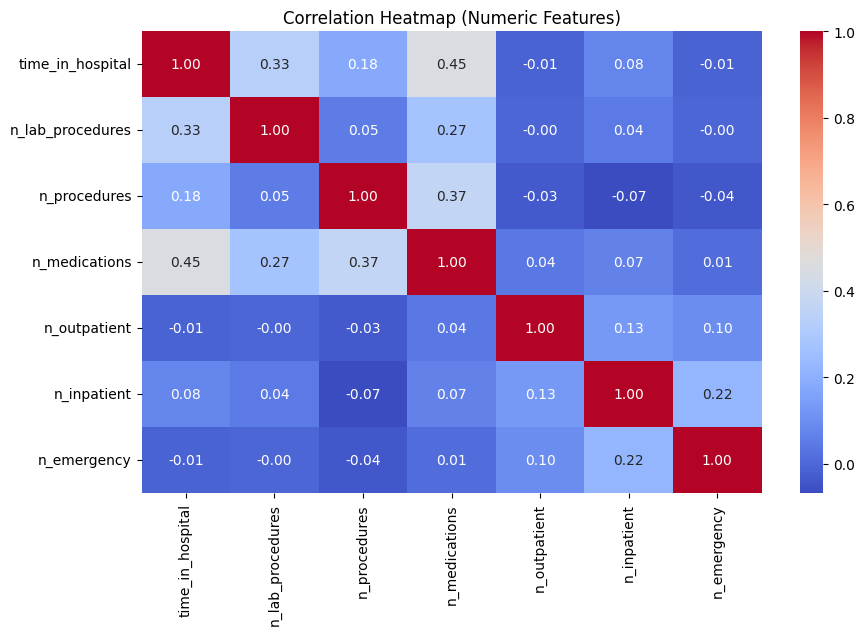

In [ ]:
# STEP 2.5: CORRELATION BETWEEN NUMERIC FEATURES
corr = df[numerical_cols].corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

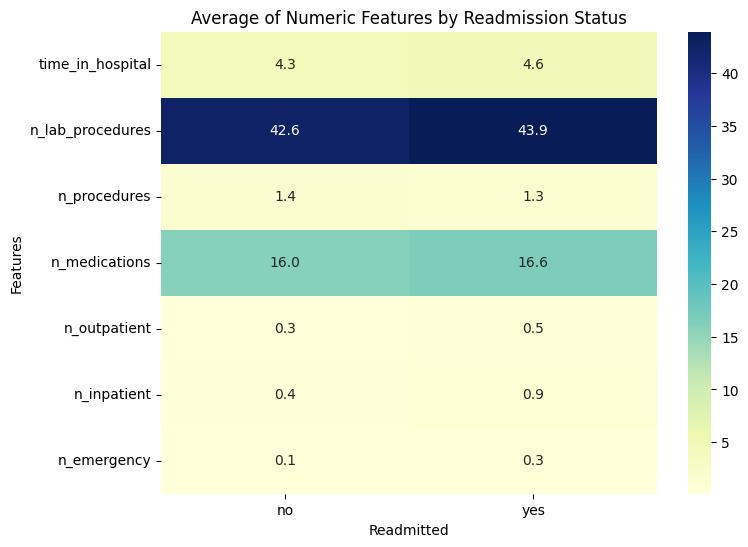

readmitted,no,yes
time_in_hospital,4.331345,4.590778
n_lab_procedures,42.625245,43.934405
n_procedures,1.424204,1.271397
n_medications,15.972445,16.567892
n_outpatient,0.258871,0.487579
n_inpatient,0.380190,0.881657
n_emergency,0.108561,0.274545


In [ ]:
# STEP 2.6: NUMERIC FEATURES VS TARGET
# Compare mean values of numeric features for readmitted vs not
group_means = df.groupby("readmitted")[numerical_cols].mean().T

plt.figure(figsize=(8,6))
sns.heatmap(group_means, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Average of Numeric Features by Readmission Status")
plt.ylabel("Features")
plt.xlabel("Readmitted")
plt.show()

group_means

In [29]:
import numpy as np

# Step 1: Compute correlation matrix
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()

# Step 2: Flatten (unstack) and sort
corr_pairs = corr_matrix.unstack().sort_values(kind="quicksort", ascending=False)

# Step 3: Remove self correlations (value = 1)
corr_pairs = corr_pairs[corr_pairs < 0.9999]

# Step 4: Top 5 positive & negative correlations
top_pos_corr = corr_pairs.head(5)
top_neg_corr = corr_pairs.tail(5)

print("Top Positive Correlations:\n", top_pos_corr)
print("\nTop Negative Correlations:\n", top_neg_corr)

Top Positive Correlations:
 time_in_hospital  n_medications       0.449415
n_medications     time_in_hospital    0.449415
n_procedures      n_medications       0.368681
n_medications     n_procedures        0.368681
time_in_hospital  n_lab_procedures    0.328326
dtype: float64

Top Negative Correlations:
 n_procedures  n_outpatient   -0.034796
n_emergency   n_procedures   -0.042906
n_procedures  n_emergency    -0.042906
              n_inpatient    -0.069078
n_inpatient   n_procedures   -0.069078
dtype: float64


In [30]:
# ==============================================
# STEP 4: FEATURE ENGINEERING
# ==============================================
print("\nSTEP 4: FEATURE ENGINEERING")
print("-" * 30)

df_engineered = df_processed.copy()

print("Creating advanced medical features...")

# 5.1 Medical Intensity Features
df_engineered['medications_per_day'] = df_engineered['n_medications'] / (df_engineered['time_in_hospital'] + 1)
df_engineered['procedures_per_day'] = df_engineered['n_procedures'] / (df_engineered['time_in_hospital'] + 1)
df_engineered['labs_per_day'] = df_engineered['n_lab_procedures'] / (df_engineered['time_in_hospital'] + 1)

# Outlier Detection and Management
# Outlier Capping using IQR Method
print("--- Outlier Management ---")
# Removed 'age_mid' as it's not created here and changed df to df_engineered for capping
numerical_features = ['time_in_hospital', 'n_lab_procedures', 'n_procedures',
                       'n_medications', 'n_outpatient', 'n_inpatient', 'n_emergency',
                       'medications_per_day', 'procedures_per_day', 'labs_per_day']




# 5.2 Total Medical Activity
df_engineered['total_medical_activity'] = (df_engineered['n_medications'] +
                                          df_engineered['n_procedures'] +
                                          df_engineered['n_lab_procedures'])

# 5.3 Healthcare Utilization History
df_engineered['total_prior_visits'] = (df_engineered['n_outpatient'] +
                                      df_engineered['n_inpatient'] +
                                      df_engineered['n_emergency'])

df_engineered['has_emergency_visits'] = (df_engineered['n_emergency'] > 0).astype(int)
df_engineered['has_inpatient_visits'] = (df_engineered['n_inpatient'] > 0).astype(int)
df_engineered['has_outpatient_visits'] = (df_engineered['n_outpatient'] > 0).astype(int)

# 5.4 Diagnosis Features
df_engineered['num_diagnoses'] = df_engineered[['diag_1', 'diag_2', 'diag_3']].count(axis=1)

# 5.5 Simplify Diagnoses
def simplify_diagnosis(diag):
    if pd.isna(diag):
        return 'Other'
    diag_str = str(diag).lower()
    if 'diabetes' in diag_str:
        return 'Diabetes'
    elif 'circulatory' in diag_str:
        return 'Circulatory'
    elif 'respiratory' in diag_str:
        return 'Respiratory'
    elif 'digestive' in diag_str:
        return 'Digestive'
    elif 'injury' in diag_str:
        return 'Injury'
    elif 'musculoskeletal' in diag_str:
        return 'Musculoskeletal'
    else:
        return 'Other'

# Apply diagnosis simplification
for col in ['diag_1', 'diag_2', 'diag_3']:
    df_engineered[col] = df_engineered[col].apply(simplify_diagnosis)

# 5.6 Create Binary Indicators for Each Diagnosis Group
diagnosis_groups = ['Diabetes', 'Circulatory', 'Respiratory', 'Digestive', 'Injury', 'Musculoskeletal', 'Other']
for diag_group in diagnosis_groups:
    df_engineered[f'has_{diag_group.lower()}_diag'] = (
        (df_engineered['diag_1'] == diag_group) |
        (df_engineered['diag_2'] == diag_group) |
        (df_engineered['diag_3'] == diag_group)
    ).astype(int)

# 5.7 Diagnosis Severity Scoring
severity_scores = {
    'Respiratory': 7,     # Highest severity
    'Circulatory': 6,     # High severity
    'Diabetes': 5,        # Moderate-high severity
    'Digestive': 4,       # Moderate severity
    'Injury': 3,          # Lower severity
    'Musculoskeletal': 2, # Lower severity
    'Other': 1            # Lowest severity
}

# Calculate severity scores
for col in ['diag_1', 'diag_2', 'diag_3']:
    df_engineered[f'{col}_severity'] = df_engineered[col].map(severity_scores)

df_engineered['max_diagnosis_severity'] = df_engineered[['diag_1_severity', 'diag_2_severity', 'diag_3_severity']].max(axis=1)
df_engineered['total_diagnosis_severity'] = df_engineered[['diag_1_severity', 'diag_2_severity', 'diag_3_severity']].sum(axis=1)

# 5.8 Age Group Simplification
def simplify_age_group(age_range):
    if pd.isna(age_range):
        return 'Unknown'
    if age_range in ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)']:
        return 'Young'
    elif age_range in ['[50-60)', '[60-70)', '[70-80)']:
        return 'Middle_aged'
    else:
        return 'Senior'

df_engineered['age_group_simplified'] = df_engineered['age'].apply(simplify_age_group)

# 5.9 Medical Specialty Grouping
top_specialties = df_engineered['medical_specialty'].value_counts().head(10).index.tolist()
df_engineered['medical_specialty_grouped'] = df_engineered['medical_specialty'].apply(
    lambda x: x if x in top_specialties else 'Other'
)

# 5.10 Risk Factors
df_engineered['high_risk_age'] = (df_engineered['age_group_simplified'] == 'Senior').astype(int)
df_engineered['long_stay'] = (df_engineered['time_in_hospital'] >= 7).astype(int)
df_engineered['high_medications'] = (df_engineered['n_medications'] >= 15).astype(int)
df_engineered['multiple_procedures'] = (df_engineered['n_procedures'] >= 3).astype(int)

print(f"Feature engineering completed!")
print(f"Original features: {df.shape[1]}")
print(f"Engineered features: {df_engineered.shape[1]}")
print(f"New features created: {df_engineered.shape[1] - df.shape[1]}")


STEP 4: FEATURE ENGINEERING
------------------------------
Creating advanced medical features...
--- Outlier Management ---
Feature engineering completed!
Original features: 17
Engineered features: 44
New features created: 27


In [31]:
# ==============================================
# STEP 5: DATA SPLITTING
# ==============================================


# Prepare feature matrix and target
columns_to_drop = ['readmitted', 'age', 'medical_specialty'] + \
                 [col for col in df_engineered.columns if col.endswith('_severity') and col not in ['max_diagnosis_severity', 'total_diagnosis_severity']]
columns_to_drop = [col for col in columns_to_drop if col in df_engineered.columns]

X = df_engineered.drop(columns_to_drop, axis=1)
y = df_engineered['readmitted']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Target values: {y.unique()}")

# ENCODE TARGET VARIABLE (CRITICAL FOR XGBOOST)
print("\n🔧 Encoding target variable...")
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)
print(f"Target encoding mapping: {dict(zip(target_encoder.classes_, target_encoder.transform(target_encoder.classes_)))}")

# First split: 75% train, 25% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded
)

# Second split: 15% validation, 10% test from temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.4, random_state=42, stratify=y_temp
)

print(f"\n Data split completed:")
print(f"Training set:   {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X):.1%})")
print(f"Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X):.1%})")
print(f"Test set:       {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X):.1%})")

# Verify stratification
print(f"\nTarget distribution verification:")
print(f"Training:   {dict(zip(*np.unique(y_train, return_counts=True)))}")
print(f"Validation: {dict(zip(*np.unique(y_val, return_counts=True)))}")
print(f"Test:       {dict(zip(*np.unique(y_test, return_counts=True)))}")

# Store target encoder for later use
print(f"\n Target variable encoded successfully!")
print(f" Target encoder stored for inverse transformation")

Feature matrix shape: (25000, 38)
Target vector shape: (25000,)
Target values: ['no' 'yes']

🔧 Encoding target variable...
Target encoding mapping: {'no': np.int64(0), 'yes': np.int64(1)}

 Data split completed:
Training set:   18,750 samples (75.0%)
Validation set: 3,750 samples (15.0%)
Test set:       2,500 samples (10.0%)

Target distribution verification:
Training:   {np.int64(0): np.int64(9934), np.int64(1): np.int64(8816)}
Validation: {np.int64(0): np.int64(1987), np.int64(1): np.int64(1763)}
Test:       {np.int64(0): np.int64(1325), np.int64(1): np.int64(1175)}

 Target variable encoded successfully!
 Target encoder stored for inverse transformation


In [32]:
# ==============================================
# STEP 6: DATA PREPARATION FOR PIPELINE & CREATION OF PIPELINE
# ==============================================
print("\n STEP 6: CREATING PROPER ML PIPELINE")
print("-" * 50)

# Define feature types for different encoding strategies
binary_features = ['diabetes_med', 'change']  # Binary: yes/no
ordinal_features = ['glucose_test', 'A1Ctest']  # Ordinal: normal < high
nominal_features = ['medical_specialty_grouped', 'diag_1', 'diag_2', 'diag_3', 'age_group_simplified']

# Numerical features (to be scaled)
numerical_features = [
    'time_in_hospital', 'n_lab_procedures', 'n_procedures', 'n_medications',
    'n_outpatient', 'n_inpatient', 'n_emergency', 'medications_per_day',
    'procedures_per_day', 'labs_per_day', 'total_medical_activity',
    'total_prior_visits', 'has_emergency_visits', 'has_inpatient_visits',
    'has_outpatient_visits', 'num_diagnoses', 'max_diagnosis_severity',
    'total_diagnosis_severity', 'high_risk_age', 'long_stay',
    'high_medications', 'multiple_procedures'
] + [f'has_{diag.lower()}_diag' for diag in diagnosis_groups]

print(f"Pipeline strategy:")
print(f"Binary features (Label Encoding): {len(binary_features)}")
print(f"Ordinal features (Label Encoding): {len(ordinal_features)}")
print(f"Nominal features (One-Hot Encoding): {len(nominal_features)}")
print(f"Numerical features (Scaling): {len(numerical_features)}")

# Create custom LabelEncoder wrapper for pipeline compatibility
from sklearn.base import BaseEstimator, TransformerMixin

class LabelEncoderWrapper(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.label_encoders = {}

    def fit(self, X, y=None):
        # X is a 2D array, we need to encode each column separately
        for i in range(X.shape[1]):
            le = LabelEncoder()
            le.fit(X[:, i])
            self.label_encoders[i] = le
        return self

    def transform(self, X):
        X_encoded = X.copy()
        for i in range(X.shape[1]):
            X_encoded[:, i] = self.label_encoders[i].transform(X[:, i])
        return X_encoded

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        # Binary and ordinal features - Label Encoding
        ('binary_ordinal', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
            ('encoder', LabelEncoderWrapper())
        ]), binary_features + ordinal_features),

        # Nominal features - One-Hot Encoding
        ('nominal', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
            ('encoder', OneHotEncoder(drop='first', sparse_output=False))
        ]), nominal_features),

        # Numerical features - Scaling
        ('numerical', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', RobustScaler())
        ]), numerical_features)
    ],
    remainder='passthrough'
)

print(" Preprocessing pipeline created!")
print(" Pipeline will fit on training data and transform all sets")


 STEP 6: CREATING PROPER ML PIPELINE
--------------------------------------------------
Pipeline strategy:
Binary features (Label Encoding): 2
Ordinal features (Label Encoding): 2
Nominal features (One-Hot Encoding): 5
Numerical features (Scaling): 29
 Preprocessing pipeline created!
 Pipeline will fit on training data and transform all sets


In [33]:
# ==============================================
# STEP 7: SYSTEMATIC MODEL DEVELOPMENT
# ==============================================
print("\n STEP 7: SYSTEMATIC MODEL DEVELOPMENT")
print("-" * 50)

# Define the 4  models for comparison
models = {
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'LightGBM': lgb.LGBMClassifier(random_state=42, verbose=-1)
}

# Create complete pipelines (preprocessing + model)
model_pipelines = {}
for name, model in models.items():
    model_pipelines[name] = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

# Train baseline models
print("Training baseline models with proper pipeline...")
baseline_results = {}

for name, pipeline in model_pipelines.items():
    print(f"\nTraining {name}...")

    # Fit pipeline on training data (preprocessing + model training)
    pipeline.fit(X_train, y_train)

    # Predictions on validation set
    y_pred = pipeline.predict(X_val)
    y_pred_proba = pipeline.predict_proba(X_val)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc_roc = roc_auc_score(y_val, y_pred_proba)

    baseline_results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,      # Primary metric
        'F1_Score': f1,
        'AUC_ROC': auc_roc,   # Secondary metric
        'Pipeline': pipeline
    }

    print(f"Recall: {recall:.4f} (Primary)")
    print(f"AUC-ROC: {auc_roc:.4f} (Secondary)")
    print(f"Precision: {precision:.4f} (Tertiary)")

# Display baseline results
baseline_df = pd.DataFrame({k: {metric: v[metric] for metric in ['Accuracy', 'Precision', 'Recall', 'F1_Score', 'AUC_ROC']}
                          for k, v in baseline_results.items()}).T
print(f"\nBASELINE RESULTS:")
print(baseline_df.round(4))


 STEP 7: SYSTEMATIC MODEL DEVELOPMENT
--------------------------------------------------
Training baseline models with proper pipeline...

Training XGBoost...
Recall: 0.5332 (Primary)
AUC-ROC: 0.6232 (Secondary)
Precision: 0.5817 (Tertiary)

Training Random Forest...
Recall: 0.5162 (Primary)
AUC-ROC: 0.6271 (Secondary)
Precision: 0.5879 (Tertiary)

Training Naive Bayes...
Recall: 0.4305 (Primary)
AUC-ROC: 0.6382 (Secondary)
Precision: 0.6191 (Tertiary)

Training LightGBM...
Recall: 0.5099 (Primary)
AUC-ROC: 0.6453 (Secondary)
Precision: 0.6103 (Tertiary)

BASELINE RESULTS:
               Accuracy  Precision  Recall  F1_Score  AUC_ROC
XGBoost          0.6003     0.5817  0.5332    0.5564   0.6232
Random Forest    0.6024     0.5879  0.5162    0.5497   0.6271
Naive Bayes      0.6077     0.6191  0.4305    0.5079   0.6382
LightGBM         0.6165     0.6103  0.5099    0.5556   0.6453


In [34]:
# ==============================================
# STEP 8: CROSS-VALIDATION & HYPERPARAMETER TUNING
# ==============================================
print("\n STEP 8: CROSS-VALIDATION & HYPERPARAMETER TUNING")
print("-" * 50)

# Define parameter grids for each model
param_grids = {
    'XGBoost': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [3, 5, 7],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__subsample': [0.8, 0.9, 1.0],
        'classifier__colsample_bytree': [0.8, 0.9, 1.0]
    },
    'Random Forest': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [10, 20, 30, None],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__max_features': ['auto', 'sqrt', 'log2']
    },
    'Naive Bayes': {
        'classifier__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
    },
    'LightGBM': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [3, 5, 7, -1],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__num_leaves': [31, 50, 100],
        'classifier__subsample': [0.8, 0.9, 1.0]
    }
}

# Custom scorer for recall (primary metric)
recall_scorer = make_scorer(recall_score)

# GRID SEARCH CV
print("\nGRID SEARCH CV (This may take several minutes...)")
grid_search_results = {}

for name, pipeline in model_pipelines.items():
    print(f"\nGrid Search for {name}...")

    if name in param_grids:
        # For computational efficiency, use smaller param grid for demonstration
        if name == 'Random Forest':
            param_grid_small = {
                'classifier__n_estimators': [100, 200],
                'classifier__max_depth': [10, 20, None],
                'classifier__min_samples_split': [2, 5]
            }
        elif name == 'XGBoost':
            param_grid_small = {
                'classifier__n_estimators': [100, 200],
                'classifier__max_depth': [3, 5],
                'classifier__learning_rate': [0.1, 0.2]
            }
        elif name == 'LightGBM':
            param_grid_small = {
                'classifier__n_estimators': [100, 200],
                'classifier__max_depth': [3, 5],
                'classifier__learning_rate': [0.1, 0.2]
            }
        else:
            param_grid_small = param_grids[name]

        grid_search = GridSearchCV(
            pipeline, param_grid_small, cv=3, scoring=recall_scorer,
            n_jobs=-1, verbose=0
        )

        grid_search.fit(X_train, y_train)

        # Evaluate on validation set
        y_pred = grid_search.predict(X_val)
        y_pred_proba = grid_search.predict_proba(X_val)[:, 1]

        grid_search_results[name] = {
            'Accuracy': accuracy_score(y_val, y_pred),
            'Precision': precision_score(y_val, y_pred),
            'Recall': recall_score(y_val, y_pred),
            'F1_Score': f1_score(y_val, y_pred),
            'AUC_ROC': roc_auc_score(y_val, y_pred_proba),
            'Best_Params': grid_search.best_params_,
            'Pipeline': grid_search.best_estimator_
        }

        print(f"Best Recall: {grid_search_results[name]['Recall']:.4f}")
        print(f"Best Params: {grid_search.best_params_}")

# RANDOM SEARCH CV
print("\nRANDOM SEARCH CV")
random_search_results = {}

for name, pipeline in model_pipelines.items():
    print(f"\nRandom Search for {name}...")

    if name in param_grids:
        # Use full parameter grids for random search
        random_search = RandomizedSearchCV(
            pipeline, param_grids[name], cv=3, scoring=recall_scorer,
            n_iter=20, n_jobs=-1, random_state=42, verbose=0
        )

        random_search.fit(X_train, y_train)

        # Evaluate on validation set
        y_pred = random_search.predict(X_val)
        y_pred_proba = random_search.predict_proba(X_val)[:, 1]

        random_search_results[name] = {
            'Accuracy': accuracy_score(y_val, y_pred),
            'Precision': precision_score(y_val, y_pred),
            'Recall': recall_score(y_val, y_pred),
            'F1_Score': f1_score(y_val, y_pred),
            'AUC_ROC': roc_auc_score(y_val, y_pred_proba),
            'Best_Params': random_search.best_params_,
            'Pipeline': random_search.best_estimator_
        }

        print(f"Best Recall: {random_search_results[name]['Recall']:.4f}")
        print(f"Best Params: {random_search.best_params_}")

print("Hyperparameter tuning completed!")


 STEP 8: CROSS-VALIDATION & HYPERPARAMETER TUNING
--------------------------------------------------

GRID SEARCH CV (This may take several minutes...)

Grid Search for XGBoost...
Best Recall: 0.5213
Best Params: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 5, 'classifier__n_estimators': 200}

Grid Search for Random Forest...
Best Recall: 0.5156
Best Params: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}

Grid Search for Naive Bayes...
Best Recall: 0.4305
Best Params: {'classifier__var_smoothing': 1e-09}

Grid Search for LightGBM...
Best Recall: 0.5315
Best Params: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 5, 'classifier__n_estimators': 200}

RANDOM SEARCH CV

Random Search for XGBoost...
Best Recall: 0.5298
Best Params: {'classifier__subsample': 0.9, 'classifier__n_estimators': 200, 'classifier__max_depth': 7, 'classifier__learning_rate': 0.2, 'classifier__colsample_bytree': 1.0}

Random Search for

In [35]:
# ==============================================
# STEP 9: MODEL COMPARISON & SELECTION
# ==============================================
print("\n STEP 9: MODEL COMPARISON & SELECTION")
print("-" * 50)

# Combine all results
all_results = {}
all_results.update({f"{k}_Baseline": v for k, v in baseline_results.items()})
all_results.update({f"{k}_GridSearch": v for k, v in grid_search_results.items()})
all_results.update({f"{k}_RandomSearch": v for k, v in random_search_results.items()})

# Create comparison DataFrame
comparison_data = {}
for name, results in all_results.items():
    comparison_data[name] = {
        'Accuracy': results['Accuracy'],
        'Precision': results['Precision'],
        'Recall': results['Recall'],        # Primary
        'F1_Score': results['F1_Score'],
        'AUC_ROC': results['AUC_ROC']      # Secondary
    }

comparison_df = pd.DataFrame(comparison_data).T
print("Model Performance Comparison:")
print(comparison_df.round(4))

# Create weighted score (Recall 50%, AUC-ROC 30%, Precision 20%)
comparison_df['Weighted_Score'] = (
    comparison_df['Recall'] * 0.5 +
    comparison_df['AUC_ROC'] * 0.3 +
    comparison_df['Precision'] * 0.2
)

print(f"\nWeighted Scores (Recall 50% + AUC-ROC 30% + Precision 20%):")
weighted_scores = comparison_df['Weighted_Score'].sort_values(ascending=False)
for model, score in weighted_scores.items():
    print(f"{model}: {score:.4f}")

# Choose best model
best_model_name = comparison_df['Weighted_Score'].idxmax()
best_pipeline = all_results[best_model_name]['Pipeline']

print(f"\n BEST Base MODEL: {best_model_name}")
print(f"Recall: {comparison_df.loc[best_model_name, 'Recall']:.4f} (Primary)")
print(f"AUC-ROC: {comparison_df.loc[best_model_name, 'AUC_ROC']:.4f} (Secondary)")
print(f"Precision: {comparison_df.loc[best_model_name, 'Precision']:.4f} (Tertiary)")
print(f"Weighted Score: {comparison_df.loc[best_model_name, 'Weighted_Score']:.4f}")


 STEP 9: MODEL COMPARISON & SELECTION
--------------------------------------------------
Model Performance Comparison:
                            Accuracy  Precision  Recall  F1_Score  AUC_ROC
XGBoost_Baseline              0.6003     0.5817  0.5332    0.5564   0.6232
Random Forest_Baseline        0.6024     0.5879  0.5162    0.5497   0.6271
Naive Bayes_Baseline          0.6077     0.6191  0.4305    0.5079   0.6382
LightGBM_Baseline             0.6165     0.6103  0.5099    0.5556   0.6453
XGBoost_GridSearch            0.5987     0.5816  0.5213    0.5498   0.6361
Random Forest_GridSearch      0.5992     0.5834  0.5156    0.5474   0.6345
Naive Bayes_GridSearch        0.6077     0.6191  0.4305    0.5079   0.6382
LightGBM_GridSearch           0.6107     0.5964  0.5315    0.5621   0.6396
XGBoost_RandomSearch          0.5869     0.5647  0.5298    0.5467   0.6199
Random Forest_RandomSearch    0.6147     0.6023  0.5309    0.5644   0.6389
Naive Bayes_RandomSearch      0.6077     0.6191  0.4305


 STEP 10: THRESHOLD OPTIMIZATION FOR RECALL
--------------------------------------------------
Threshold range: 0.4 to 0.6 (as requested)
Optimizing threshold for Random Forest_RandomSearch...
Optimal threshold: 0.400
Recall at optimal threshold: 0.7561


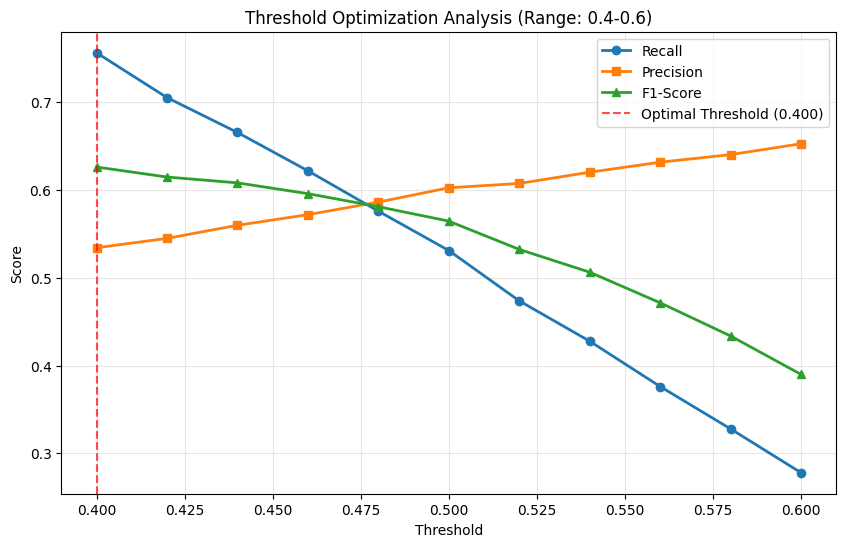

In [38]:
# ==============================================
# STEP 10: THRESHOLD OPTIMIZATION (0.4 to 0.6)
# ==============================================
print("\n STEP 10: THRESHOLD OPTIMIZATION FOR RECALL")
print("-" * 50)
print("Threshold range: 0.4 to 0.6 (as requested)")

print(f"Optimizing threshold for {best_model_name}...")

# Get prediction probabilities on validation set
y_val_proba = best_pipeline.predict_proba(X_val)[:, 1]

# Test different thresholds (YOUR REQUESTED RANGE: 0.4 to 0.6)
thresholds = np.arange(0.4, 0.61, 0.02)  # 0.4, 0.42, 0.44, ..., 0.6
threshold_results = []

best_threshold = 0.5
best_recall = 0

for threshold in thresholds:
    y_pred_thresh = (y_val_proba >= threshold).astype(int)

    recall = recall_score(y_val, y_pred_thresh)
    precision = precision_score(y_val, y_pred_thresh)
    f1 = f1_score(y_val, y_pred_thresh)

    threshold_results.append({
        'threshold': threshold,
        'recall': recall,
        'precision': precision,
        'f1': f1
    })

    if recall > best_recall:
        best_recall = recall
        best_threshold = threshold

print(f"Optimal threshold: {best_threshold:.3f}")
print(f"Recall at optimal threshold: {best_recall:.4f}")

# Plot threshold analysis
plt.figure(figsize=(10, 6))
thresholds_plot = [r['threshold'] for r in threshold_results]
recalls_plot = [r['recall'] for r in threshold_results]
precisions_plot = [r['precision'] for r in threshold_results]
f1s_plot = [r['f1'] for r in threshold_results]

plt.plot(thresholds_plot, recalls_plot, label='Recall', linewidth=2, marker='o')
plt.plot(thresholds_plot, precisions_plot, label='Precision', linewidth=2, marker='s')
plt.plot(thresholds_plot, f1s_plot, label='F1-Score', linewidth=2, marker='^')
plt.axvline(x=best_threshold, color='red', linestyle='--', alpha=0.7,
            label=f'Optimal Threshold ({best_threshold:.3f})')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Optimization Analysis (Range: 0.4-0.6)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


 STEP 11: FINAL EVALUATION ON TEST SET
--------------------------------------------------
Evaluating Random Forest_RandomSearch on test set with threshold 0.400...

FINAL TEST SET PERFORMANCE:

With Default Threshold (0.5):
   Accuracy: 0.6096
   Precision: 0.5996
   Recall: 0.5098
   F1_Score: 0.5511
   AUC_ROC: 0.6468

With Optimal Threshold (0.400):
   Accuracy: 0.5824
   Precision: 0.5393
   Recall: 0.7651
   F1_Score: 0.6327
   AUC_ROC: 0.6468

Improvement with optimal threshold:
   Recall: +0.2553
   Precision: -0.0603


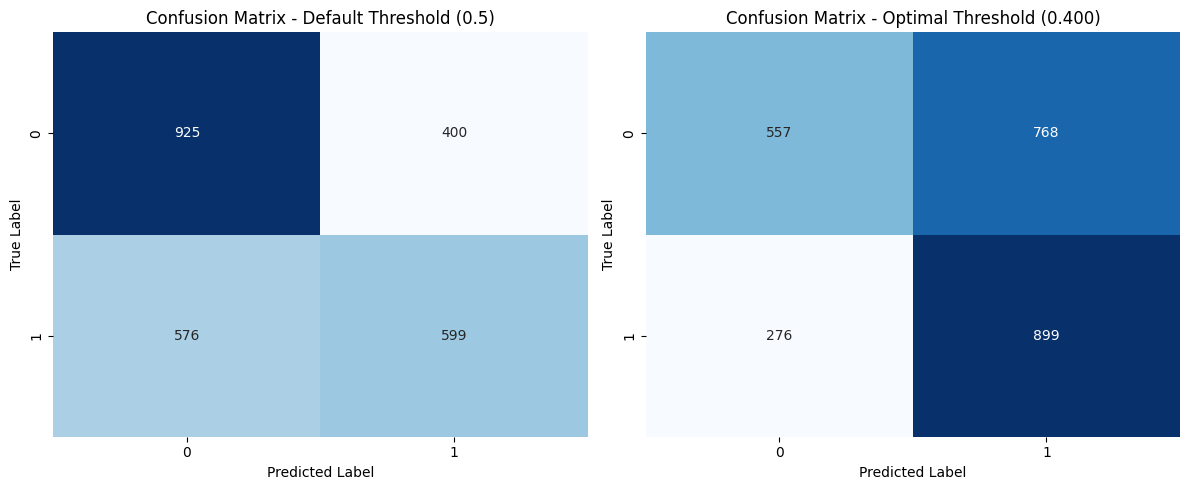

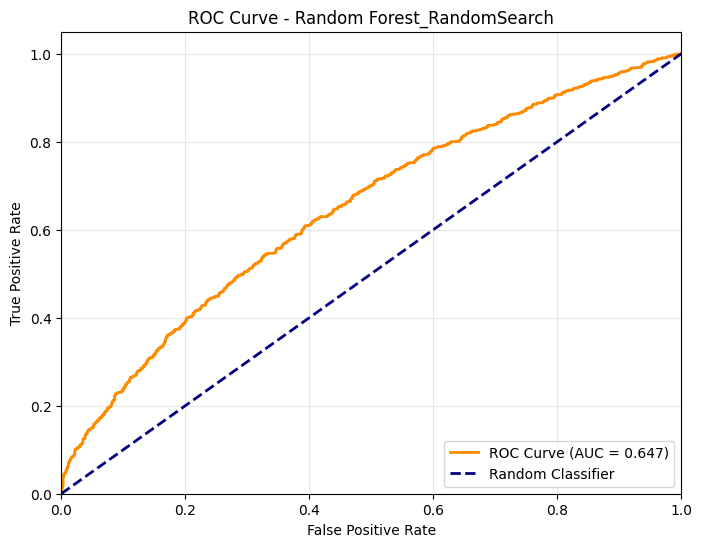


DETAILED CLASSIFICATION REPORT:
Model: Random Forest_RandomSearch
Threshold: 0.400
--------------------------------------------------
                precision    recall  f1-score   support

No Readmission       0.67      0.42      0.52      1325
   Readmission       0.54      0.77      0.63      1175

      accuracy                           0.58      2500
     macro avg       0.60      0.59      0.57      2500
  weighted avg       0.61      0.58      0.57      2500



In [39]:
# ==============================================
# STEP 11: FINAL EVALUATION ON TEST SET
# ==============================================
print("\n STEP 11: FINAL EVALUATION ON TEST SET")
print("-" * 50)

print(f"Evaluating {best_model_name} on test set with threshold {best_threshold:.3f}...")

# Make predictions on test set
y_test_proba = best_pipeline.predict_proba(X_test)[:, 1]
y_test_pred_default = best_pipeline.predict(X_test)  # Default threshold (0.5)
y_test_pred_optimal = (y_test_proba >= best_threshold).astype(int)  # Optimal threshold

# Calculate final metrics
final_metrics_default = {
    'Accuracy': accuracy_score(y_test, y_test_pred_default),
    'Precision': precision_score(y_test, y_test_pred_default),
    'Recall': recall_score(y_test, y_test_pred_default),
    'F1_Score': f1_score(y_test, y_test_pred_default),
    'AUC_ROC': roc_auc_score(y_test, y_test_proba)
}

final_metrics_optimal = {
    'Accuracy': accuracy_score(y_test, y_test_pred_optimal),
    'Precision': precision_score(y_test, y_test_pred_optimal),
    'Recall': recall_score(y_test, y_test_pred_optimal),
    'F1_Score': f1_score(y_test, y_test_pred_optimal),
    'AUC_ROC': roc_auc_score(y_test, y_test_proba)
}

print(f"\nFINAL TEST SET PERFORMANCE:")
print(f"\nWith Default Threshold (0.5):")
for metric, score in final_metrics_default.items():
    print(f"   {metric}: {score:.4f}")

print(f"\nWith Optimal Threshold ({best_threshold:.3f}):")
for metric, score in final_metrics_optimal.items():
    print(f"   {metric}: {score:.4f}")

print(f"\nImprovement with optimal threshold:")
print(f"   Recall: {final_metrics_optimal['Recall'] - final_metrics_default['Recall']:+.4f}")
print(f"   Precision: {final_metrics_optimal['Precision'] - final_metrics_default['Precision']:+.4f}")

# Confusion Matrix
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm_default = confusion_matrix(y_test, y_test_pred_default)
sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix - Default Threshold (0.5)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.subplot(1, 2, 2)
cm_optimal = confusion_matrix(y_test, y_test_pred_optimal)
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix - Optimal Threshold ({best_threshold:.3f})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {final_metrics_optimal["AUC_ROC"]:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_model_name}')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Classification Report
print(f"\nDETAILED CLASSIFICATION REPORT:")
print("=" * 50)
print(f"Model: {best_model_name}")
print(f"Threshold: {best_threshold:.3f}")
print("-" * 50)
print(classification_report(y_test, y_test_pred_optimal,
                          target_names=['No Readmission', 'Readmission']))

In [40]:
# ==============================================
# STEP 12: STACKING CLASSIFIER
# ==============================================
print("\n STEP 12: STACKING CLASSIFIER")
print("-" * 50)

# Import StackingClassifier and LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Create stacking classifier with best models
print("Creating Stacking Classifier...")

# Use top 3 models as base estimators
top_models = comparison_df.nlargest(3, 'Weighted_Score').index.tolist()
base_estimators = []

for model_name in top_models:
    if 'Baseline' in model_name:
        model_type = model_name.replace('_Baseline', '')
        if model_type == 'XGBoost':
            base_estimators.append(('xgb', xgb.XGBClassifier(random_state=42, eval_metric='logloss')))
        elif model_type == 'Random Forest':
            base_estimators.append(('rf', RandomForestClassifier(random_state=42)))
        elif model_type == 'Naive Bayes':
            base_estimators.append(('nb', GaussianNB()))
        elif model_type == 'LightGBM':
            base_estimators.append(('lgb', lgb.LGBMClassifier(random_state=42, verbose=-1)))
    elif 'GridSearch' in model_name:
        model_type = model_name.replace('_GridSearch', '')
        if model_type == 'XGBoost':
            base_estimators.append(('xgb_tuned', xgb.XGBClassifier(random_state=42, eval_metric='logloss')))
        elif model_type == 'Random Forest':
            base_estimators.append(('rf_tuned', RandomForestClassifier(random_state=42)))
        elif model_type == 'Naive Bayes':
            base_estimators.append(('nb_tuned', GaussianNB()))
        elif model_type == 'LightGBM':
            base_estimators.append(('lgb_tuned', lgb.LGBMClassifier(random_state=42, verbose=-1)))
    elif 'RandomSearch' in model_name:
        model_type = model_name.replace('_RandomSearch', '')
        if model_type == 'XGBoost':
            base_estimators.append(('xgb_rand', xgb.XGBClassifier(random_state=42, eval_metric='logloss')))
        elif model_type == 'Random Forest':
            base_estimators.append(('rf_rand', RandomForestClassifier(random_state=42)))
        elif model_type == 'Naive Bayes':
            base_estimators.append(('nb_rand', GaussianNB()))
        elif model_type == 'LightGBM':
            base_estimators.append(('lgb_rand', lgb.LGBMClassifier(random_state=42, verbose=-1)))

# Create stacking classifier
stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(random_state=42),
    cv=5
)

# Create complete pipeline with stacking
stacking_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('stacking', stacking_clf)
])

# Train stacking classifier
print("Training Stacking Classifier...")
stacking_pipeline.fit(X_train, y_train)

# Evaluate stacking classifier
y_pred_stack = stacking_pipeline.predict(X_test)
y_pred_proba_stack = stacking_pipeline.predict_proba(X_test)[:, 1]

stacking_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_stack),
    'Precision': precision_score(y_test, y_pred_stack),
    'Recall': recall_score(y_test, y_pred_stack),
    'F1_Score': f1_score(y_test, y_pred_stack),
    'AUC_ROC': roc_auc_score(y_test, y_pred_proba_stack)
}

print(f"\nSTACKING CLASSIFIER PERFORMANCE:")
for metric, score in stacking_metrics.items():
    print(f"   {metric}: {score:.4f}")

# Compare with best single model
print(f"\nCOMPARISON WITH BEST SINGLE MODEL:")
print(f"Best Single Model ({best_model_name}):")
print(f"   Recall: {final_metrics_optimal['Recall']:.4f}")
print(f"   AUC-ROC: {final_metrics_optimal['AUC_ROC']:.4f}")

print(f"\nStacking Classifier:")
print(f"   Recall: {stacking_metrics['Recall']:.4f}")
print(f"   AUC-ROC: {stacking_metrics['AUC_ROC']:.4f}")

print(f"\nImprovement:")
print(f"   Recall: {stacking_metrics['Recall'] - final_metrics_optimal['Recall']:+.4f}")
print(f"   AUC-ROC: {stacking_metrics['AUC_ROC'] - final_metrics_optimal['AUC_ROC']:+.4f}")


 STEP 12: STACKING CLASSIFIER
--------------------------------------------------
Creating Stacking Classifier...
Training Stacking Classifier...

STACKING CLASSIFIER PERFORMANCE:
   Accuracy: 0.6196
   Precision: 0.6157
   Recall: 0.5072
   F1_Score: 0.5562
   AUC_ROC: 0.6565

COMPARISON WITH BEST SINGLE MODEL:
Best Single Model (Random Forest_RandomSearch):
   Recall: 0.7651
   AUC-ROC: 0.6468

Stacking Classifier:
   Recall: 0.5072
   AUC-ROC: 0.6565

Improvement:
   Recall: -0.2579
   AUC-ROC: +0.0098



 STEP 15: COMPREHENSIVE VISUALIZATIONS
------------------------------


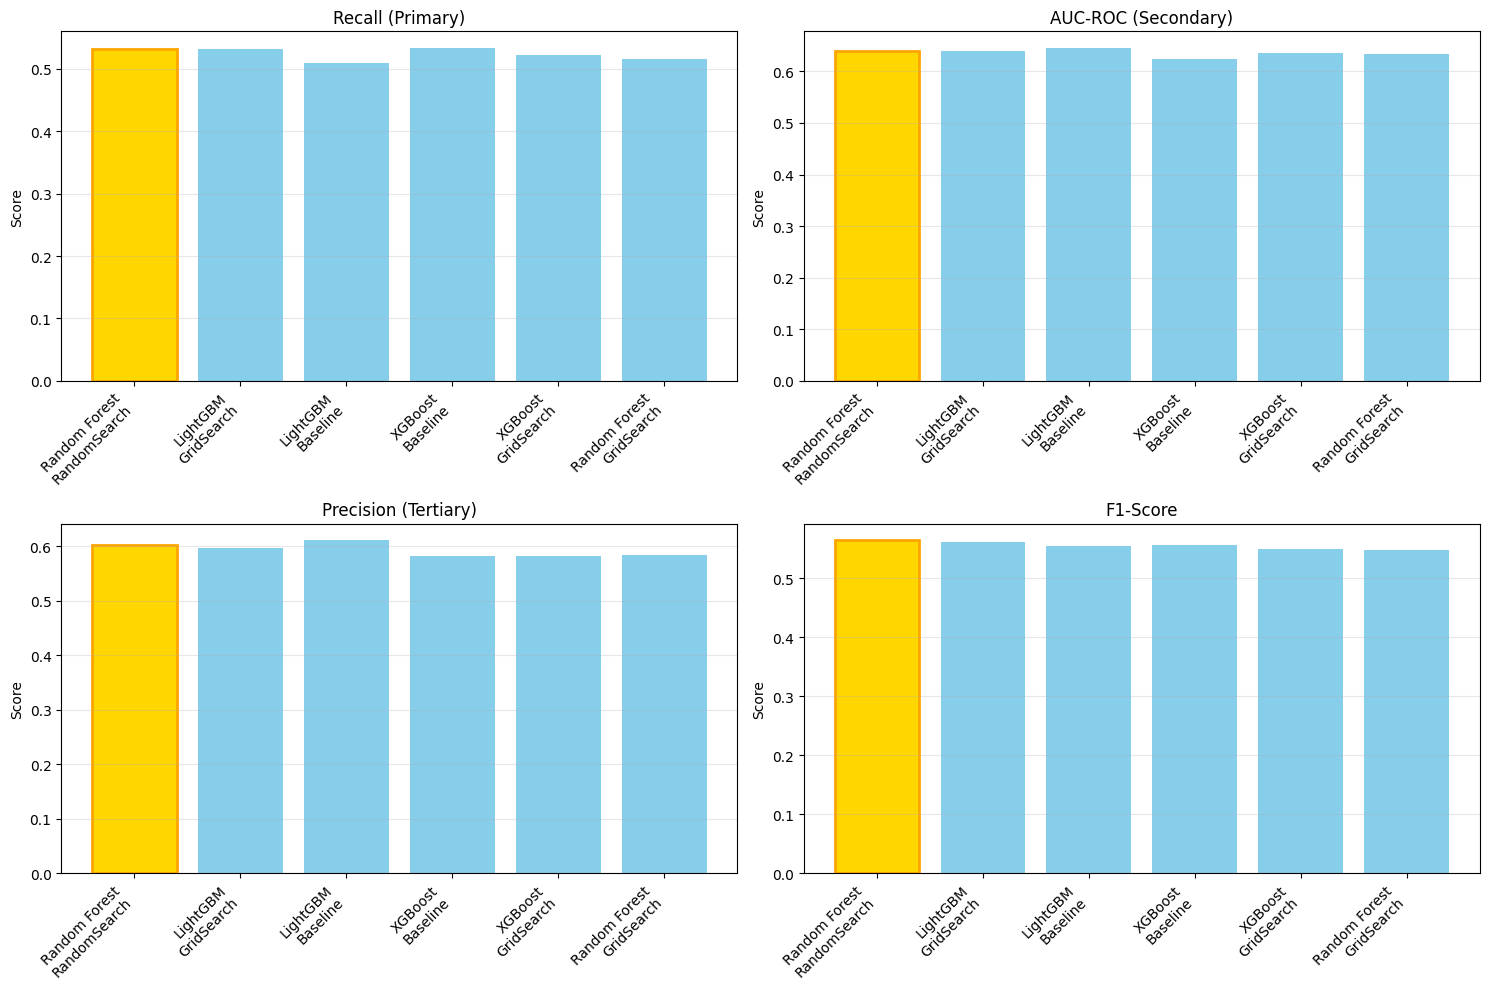

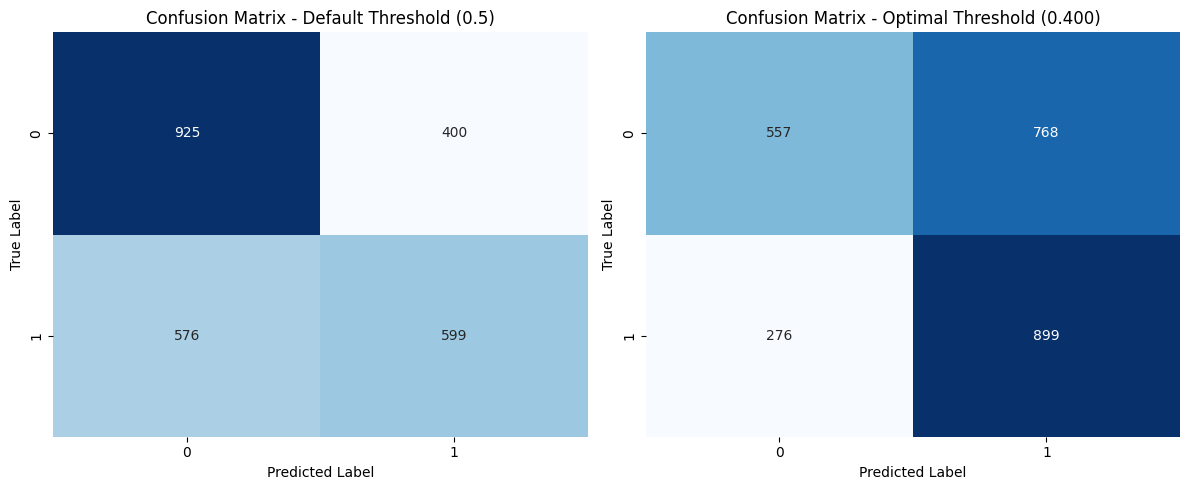

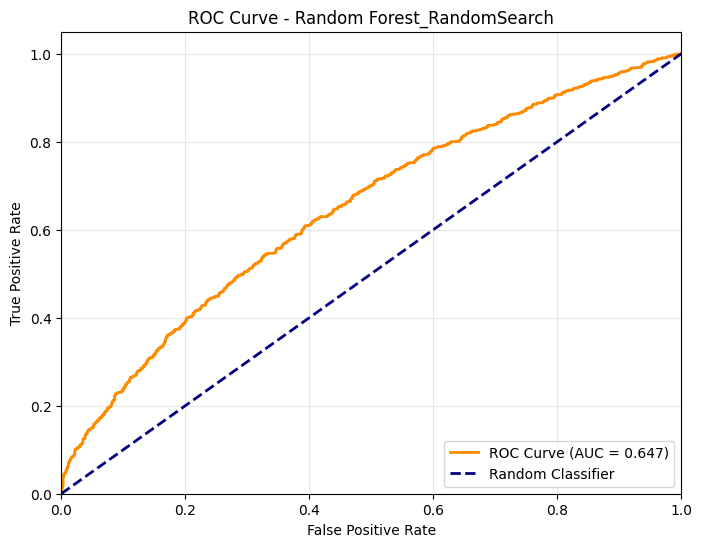


15.5 Model Performance Summary
                     Model Best Threshold Test Recall Test AUC-ROC Test Precision Test F1-Score Test Accuracy
Random Forest_RandomSearch          0.400      0.7651       0.6468         0.5393        0.6327        0.5824

15.6 Threshold Analysis Summary
Threshold Range Tested: 0.4 - 0.6
Optimal Threshold: 0.400
Recall at Optimal: 0.7561
Improvement over Default (0.5):
  Recall: +0.2553
  Precision: -0.0603

 COMPREHENSIVE VISUALIZATIONS COMPLETED!


In [41]:
# ==============================================
# STEP 15: COMPREHENSIVE VISUALIZATIONS
# ==============================================
print("\n STEP 15: COMPREHENSIVE VISUALIZATIONS")
print("-" * 30)

# 15.1 Model Comparison Chart
plt.figure(figsize=(15, 10))

# Model performance comparison
metrics = ['Recall', 'AUC_ROC', 'Precision', 'F1_Score']
metric_labels = ['Recall (Primary)', 'AUC-ROC (Secondary)', 'Precision (Tertiary)', 'F1-Score']

for i, (metric, label) in enumerate(zip(metrics, metric_labels), 1):
    plt.subplot(2, 2, i)

    # Get top 6 models for better visualization
    top_models = comparison_df.nlargest(6, 'Weighted_Score').index
    values = [comparison_df.loc[model, metric] for model in top_models]

    bars = plt.bar(range(len(top_models)), values,
                  color=['gold' if model == best_model_name else 'skyblue' for model in top_models])

    plt.title(f'{label}')
    plt.ylabel('Score')
    plt.xticks(range(len(top_models)), [model.replace('_', '\n') for model in top_models],
               rotation=45, ha='right')

    # Highlight best model
    for j, bar in enumerate(bars):
        if top_models[j] == best_model_name:
            bar.set_color('gold')
            bar.set_edgecolor('orange')
            bar.set_linewidth(2)

    plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 15.2 Confusion Matrix
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm_default = confusion_matrix(y_test, y_test_pred_default)
sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix - Default Threshold (0.5)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.subplot(1, 2, 2)
cm_optimal = confusion_matrix(y_test, y_test_pred_optimal)
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix - Optimal Threshold ({best_threshold:.3f})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# 15.3 ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {final_metrics_optimal["AUC_ROC"]:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_model_name}')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()



# 15.5 Model Performance Summary Table
print("\n15.5 Model Performance Summary")
print("=" * 60)
summary_data = {
    'Model': [best_model_name],
    'Best Threshold': [f"{best_threshold:.3f}"],
    'Test Recall': [f"{final_metrics_optimal['Recall']:.4f}"],
    'Test AUC-ROC': [f"{final_metrics_optimal['AUC_ROC']:.4f}"],
    'Test Precision': [f"{final_metrics_optimal['Precision']:.4f}"],
    'Test F1-Score': [f"{final_metrics_optimal['F1_Score']:.4f}"],
    'Test Accuracy': [f"{final_metrics_optimal['Accuracy']:.4f}"]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# 15.6 Threshold Analysis Summary
print(f"\n15.6 Threshold Analysis Summary")
print("=" * 40)
print(f"Threshold Range Tested: 0.4 - 0.6")
print(f"Optimal Threshold: {best_threshold:.3f}")
print(f"Recall at Optimal: {best_recall:.4f}")
print(f"Improvement over Default (0.5):")
print(f"  Recall: {final_metrics_optimal['Recall'] - final_metrics_default['Recall']:+.4f}")
print(f"  Precision: {final_metrics_optimal['Precision'] - final_metrics_default['Precision']:+.4f}")

print("\n COMPREHENSIVE VISUALIZATIONS COMPLETED!")